In [71]:
from pandas.core.nanops import nanmean as pd_nanmean
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels. tsa.stattools import adfuller
import seaborn as sns
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

## 1. Проверка ряда на стационарность.

In [92]:
df = pd.read_excel(io="Data.xlsx")
df = df.sort_values('Date')
df.index = df.Date
df = df.drop('Date', axis=1)

#### Визуальная проверка

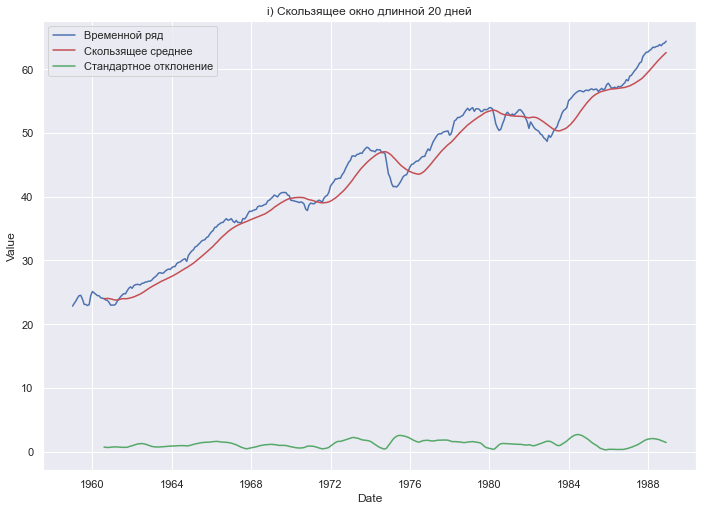

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")
sns.lineplot(color='b', x="Date", y="Value", data=df);
sns.lineplot(color='r', x="Date", y=df['Value'].rolling(window=20).mean(), data=df);
sns.lineplot(color='g', x="Date", y=df['Value'].rolling(window=20).std(), data=df);
plt.title('i) Скользящее окно длинной 20 дней')
plt.legend(labels=['Временной ряд','Скользящее среднее','Стандартное отклонение'])
plt.show()

#### Тест Дики-Фуллера

In [5]:
fuller = adfuller(df.Value.values)
if fuller[0] > fuller[4]['5%']: #сравним p-значение и критическое значение 5% 
    print('ii) Ряд не стационарен')
else:
    print('ii) Ряд стационарен')

ii) Ряд не стационарен


####   Вывод: основываясь на полученных результатах, можно заключить, что ряд не является стационарным, также, из приведенного графика, следует основная тенденция к росту.

## 2. Разложение временного ряда на тренд, сезональность и остаток в соответствии с аддитивной, мультипликативной моделями.


In [6]:
def test_D_F(sr):
    sr = sr.dropna()
    fuller = adfuller(sr.values)
    if fuller[0] > fuller[4]['5%']: #сравним p-значение и критическое значение 5% 
        return 'ряд не стационарен.'
    else:
        return 'ряд стационарен.'

def decomposition(df, model):
    x = df.index
    r = statsmodels.tsa.seasonal.seasonal_decompose(df, model = model)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="darkgrid")
    sns.lineplot(color='r', x="Date", y=r.seasonal, data=df);
    sns.lineplot(color='b', x="Date", y=r.trend, data=df);
    sns.lineplot(color='g', x="Date", y=r.resid, data=df);
    plt.title('Разложение временного ряда в соответствии с ' + model + " моделью")
    plt.legend(labels=['Сезонность','Тренд','Остаток'])
    plt.ylabel("Value")
    plt.show()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
    sns.lineplot(color='r', x="Date", y=r.seasonal, data=df, ax=ax1);
    ax1.set_ylabel("")
    ax1.set_title('Сезонность')
    sns.lineplot(color='b', x="Date", y=r.trend, data=df, ax=ax2);
    ax2.set_ylabel("")
    ax2.set_title('Тренд')
    sns.lineplot(color='g', x="Date", y=r.resid, data=df, ax=ax3);
    ax3.set_ylabel("") 
    ax3.set_title('Остаток')
    plt.show()
    print("Результаты теста Дики-Фуллера: ")
    print('   1) Сезонность - '+ test_D_F(r.seasonal))
    print('   2) Тренд - '+ test_D_F(r.trend))
    print('   3) Остаток - '+ test_D_F(r.resid))

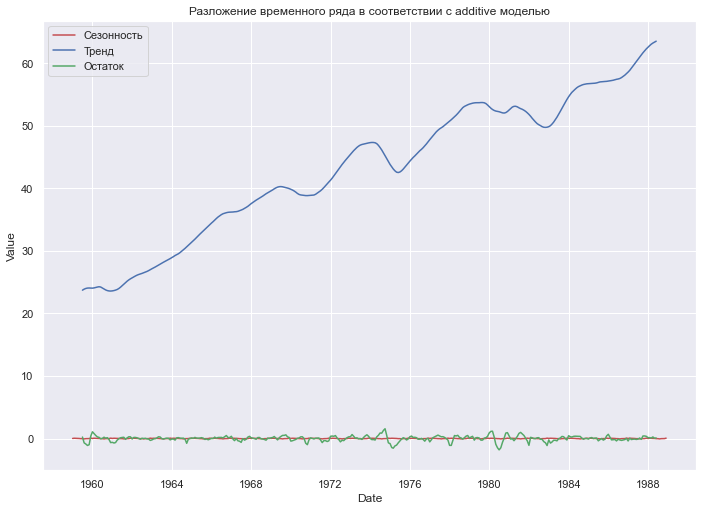

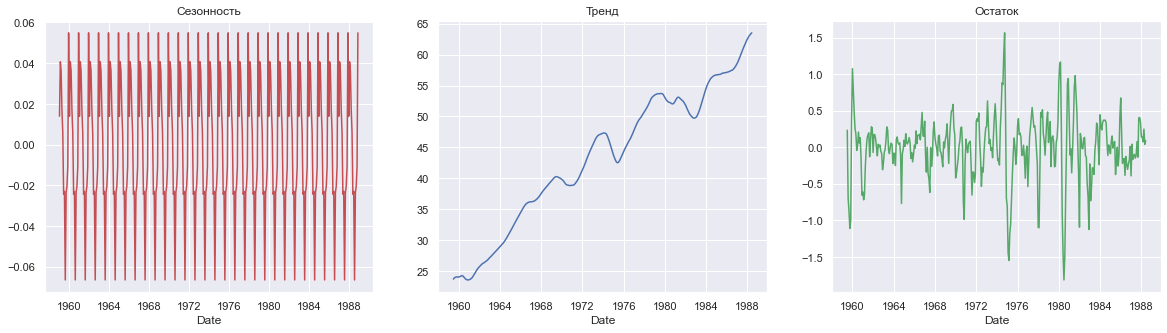

Результаты теста Дики-Фуллера: 
   1) Сезонность - ряд стационарен.
   2) Тренд - ряд не стационарен.
   3) Остаток - ряд стационарен.


In [7]:
decomposition(df, 'additive')

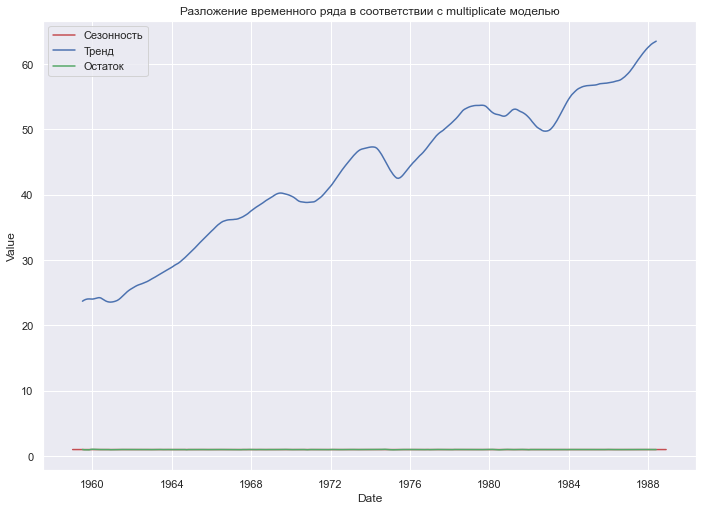

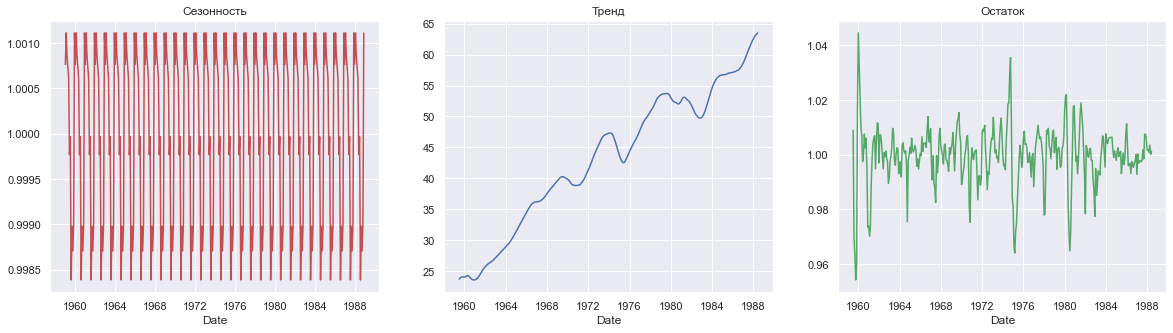

Результаты теста Дики-Фуллера: 
   1) Сезонность - ряд стационарен.
   2) Тренд - ряд не стационарен.
   3) Остаток - ряд стационарен.


In [8]:
decomposition(df, 'multiplicate')

#### Вывод: после разложения временного ряда на тренд, сезональность и остаток можем увидеть, что как для аддитивной модели, так и для мультипликативной модели, тренд является не стационарным рядом, однако сезонность и остаток обладают стационарностью.

## 3. Интегрируемость ряда. Модель ARIMA

In [9]:
def test_D_F_ft(sr):
    sr = sr.dropna()
    fuller = adfuller(sr.values)
    if fuller[0] > fuller[4]['5%']: #сравним p-значение и критическое значение 5% 
        return False
    else:
        return True

def inter_k(s):
    k = 0
    while not test_D_F_ft(s):
        s = s.diff().dropna()
        k += 1
    return k

k = inter_k(df['Value'])
print("Коэффициент интегрируемости ряда: ", k)

Коэффициент интегрируемости ряда:  1


#### Подбирем параметры с помощью функции автокорреляции и функции частичной автокорреляции

Параметры: p = 1 и q = 1


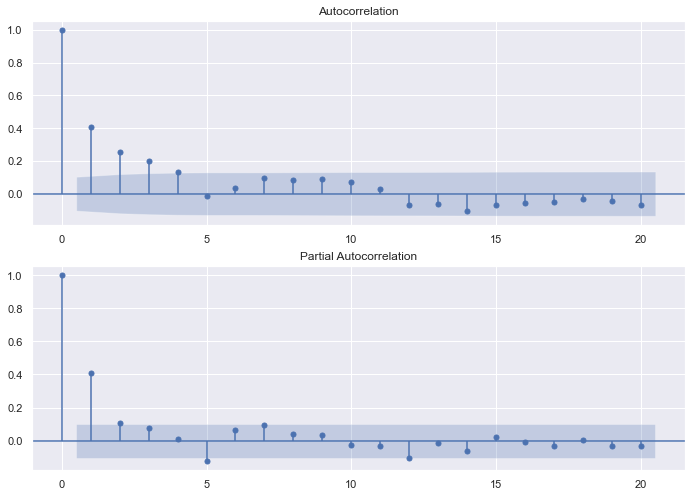

In [60]:
sr = df.Value
sr1 = sr.diff(periods=1).dropna()

lag_acf = acf(sr1, nlags=20, fft = False)
lag_pacf = pacf(sr1, nlags=20, method='ols')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(sr1, lags=20, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(sr1, lags=20, ax=ax2)

q = int(lag_acf[0])
p = int(lag_pacf[0])

print('Параметры: p =', p,'и q =', q )

#### Поскольку только на одном лаге корреляционная функция отличается от нуля (p = 1), а поcле первого лага значения функции резко падают (q = 1), то мы можем сделать вывод об оптимальных параметрах модели ARIMA:  (p = 1, q = 1).

In [127]:
# ARIMA model
df = pd.read_excel(io="Data.xlsx")
df.index = df.Date
sr = df.Value
model = sm.tsa.arima.ARIMA(sr, order=(1, 1, 1))  # Применяем модель ARIMA
model = model.fit()
print(model.summary())
result = model.predict('1988-12-01', '1993-12-01', typ='levels')

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.821
Date:                Mon, 05 Dec 2022   AIC                            255.641
Time:                        21:36:32   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7401      0.065     11.465      0.000       0.614       0.867
ma.L1         -0.3684      0.080     -4.599      0.000      -0.525      -0.211
sigma2         0.1173      0.006     20.413      0.0

C:\Users\daria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\daria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\daria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


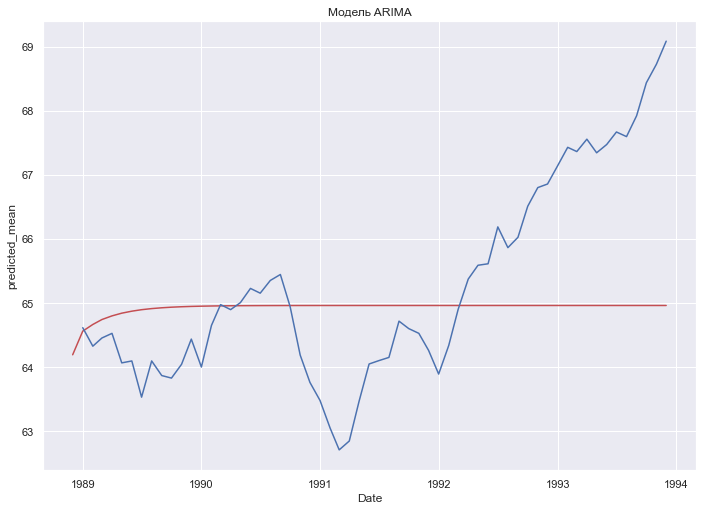

R2_score:  -0.024452987346194277
AIC (критерий Акаике): 255.64135490116269


In [128]:
df2 = pd.read_excel(io="Answers.xlsx")
df2 = df2.sort_values('Date')
df2.index = df2.Date
df2 = df2.drop('Date', axis=1) 
sr2 = df2.Value
r2 = r2_score(sr2, result['1988-12-02':])

sns.lineplot(color='r', data=result);
sns.lineplot(color='b', data=sr2);
plt.title("Модель ARIMA")
plt.show()
print("R2_score: ", r2)
print("AIC (критерий Акаике):", model.aic)


Вывод: как видим, коэффициент r2_score = -0.02, а критерий Акаике = 255.6